Projeto desenvolvido por: [Gabriel Pacheco](https://linkedin.com/in/gabriel-pacheco37)

---
## Análise de crédito baseada em modelos estatísticos

Criação de um modelo que irá prever se um cliente tem a propensão a honrar um empréstimo.

**Hipótese:** É possível criar um modelo estatístico de análise de crédito que apresente maior assertividade que o modelo `AS-IS`

**Conclusão:** TBD

---
Para alcançarmos este resultados vamos seguir os seguintes passos:
 - Tratamento e análise inicial dos dados
 - Criação do modelo baseline
 - Refinamento das soluções
 - Análise dos resultados

### Tratamento e análise inicial dos dados

Nesta etapa nós conhecemos melhor os dados e tratamos algumas anomalias, conforme o seguinte resumo:
- Foram identificadas 144k linhas e 151 colunas no dataset inicial.
- As classes se encontram desbalanceadas com 4 maus pagadores para cada 1 bom pagador.
- Foram excluídas as colunas ID e REF_DATE, que não apresentam valor significativo para o modelo.
- Foi identificado que todas as linhas possuiam pelo menos um valor nulo e estes valores foram tratados da seguinte forma:
    - Foram excluídas 59 colunas com mais de 10% de valores nulos.
    - Foram excluídas 3545 linhas com mais de 10% de valores nulos.
    - Foram excluídas linhas com TARGET positivo e com valores nulos.
    - Os demais valores foram inseridos usando KNNImputer.
- Foi realizado o encoding das váriaveis categóricas respeitando a sua ordem natural.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import warnings

warnings.filterwarnings("ignore")
pd.set_option("max_columns", None)
sns.set_theme()

In [2]:
train_file = "../datasets/credit_01/train.csv"
test_file = "../datasets/credit_01/test.csv"

train_raw = pd.read_csv(train_file)

In [3]:
train_raw.head(5)

,REF_DATE,TARGET,VAR2,IDADE,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR10,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR31,VAR32,VAR33,VAR34,VAR35,VAR36,VAR37,VAR38,VAR39,VAR40,VAR41,VAR42,VAR43,VAR44,VAR45,VAR46,VAR47,VAR48,VAR49,VAR50,VAR51,VAR52,VAR53,VAR54,VAR55,VAR56,VAR57,VAR58,VAR59,VAR60,VAR61,VAR62,VAR63,VAR64,VAR65,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR143,VAR144,VAR145,VAR146,VAR147,VAR148,VAR149,ID
0,2017-01-25 00:00:00+00:00,1,F,24.471,NaN,SP,-23.549841,-46.959865,E,E,ALTA,0.0,0.095,NaN,0.222,0.192,0.083333,NaN,0.983562,2.200000,NaN,NaN,0.125,NaN,0.017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378548,0.451697,0.438720,0.499008,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,S,N,N,N,N,N,S,S,N,N,N,N,MEDIA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTA,MEDIA,MEDIA,ALTA,ALTA,ALTA,ALTA,MEDIA,MEDIA,MEDIA,ALTA,BAIXISSIMA,MEDIA,MEDIA,ALTA,ALTA,ALTA,MEDIA,ALTA,ALTA,MEDIA,ALTISSIMA,MEDIA,LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,LONGE,PROXIMO,MEDIO,MEDIO,LONGE,MEDIO,MEDIO,LONGE,LONGE,MEDIO,MEDIO,LONGE,MUITO LONGE,MEDIO,LONGE,LONGE,LONGE,MEDIO,MEDIO,MEDIO,LONGE,LONGE,MEDIO,LONGE,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,LONGE,MEDIO,LONGE,MEDIO,1399.037809,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,280764
1,2017-04-03 00:00:00+00:00,1,F,35.041,NaN,BA,-12.924251,-38.487840,E,E,ALTA,0.0,0.005,NaN,0.120,NaN,0.166667,NaN,1.101370,NaN,NaN,NaN,NaN,NaN,0.017,NaN,NaN,NaN,0.0,NaN,0.063,NaN,NaN,NaN,NaN,S,S,198.0,NaN,0.476678,0.401271,0.393429,0.508360,NaN,NaN,NaN,NaN,0.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTA,ALTISSIMA,ALTA,MEDIO,MEDIO,PROXIMO,MEDIO,LONGE,LONGE,LONGE,PROXIMO,MEDIO,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,PROXIMO,MUITO LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,LONGE,PROXIMO,MEDIO,PROXIMO,LONGE,PROXIMO,MEDIO,MEDIO,MEDIO,PROXIMO,PROXIMO,MEDIO,MEDIO,MEDIO,MEDIO,1516.196234,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,270129
2,2017-07-13 00:00:00+00:00,1,M,63.518,NaN,PI,-5.063743,-42.761499,E,E,MEDIA,0.0,NaN,NaN,0.156,0.117,NaN,NaN,1.446575,1.446575,NaN,NaN,0.125,NaN,0.017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.532506,0.484427,0.546715,0.480883,NaN,NaN,NaN,NaN,1.000,NaN,S,N,N,N,N,N,N,S,N,N,N,N,N,N,N,N,N,ALTISSIMA,ALTA,ALTA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,BAIXISSIMA,ALTISSIMA,ALTISSIMA,ALTA,MEDIA,ALTA,ALTA,BAIXISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTISSIMA,ALTISSIMA,ALTA,ALTA,ALTISSIMA,MEDIA,ALTISSIMA,ALTISSIMA,ALTISSIMA,ALTISSIMA,LONGE,MEDIO,LONGE,MEDIO,PROXIMO,MEDIO,PROXIMO,MUITO PROXIMO,LONGE,PROXIMO,PROXIMO,MEDIO,LONGE,MUITO LONGE,PROXIMO,LONGE,MEDIO,PROXIMO,MUITO LONGE,LONGE,PROXIMO,MUITO LONGE,MEDIO,PROXIMO,MEDIO,PROXIMO,LONGE,LONGE,MEDIO,PROXIMO,MEDIO,MEDIO,PROXIMO,PROXIMO,PROXIMO,LONGE,MEDIO,MEDIO,MEDIO,1727.153575,E,NaN,NaN,NaN,NaN,102,EMAIL INEXISTENTE,2.6.1,257358
3,2017-01-27 00:00:00+00:00,1,F,47.452,NaN,PA,-0.623754,-47.345800,NaN,E,ALTISSIMA,NaN,NaN,NaN,0.096,0.022,NaN,NaN,0.482192,0.482192,0.011,NaN,0.125,NaN,0.138,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,227.0,NaN,0.273552,0.533198,0.786395,0.462936,NaN,NaN,NaN,NaN,0.000,NaN,S,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N,MEDIA,BAIXISSIMA,BAIXISSIMA,BAIXISSIMA,MEDIA,MEDIA,BAI

In [4]:
shape = train_raw.shape
label_counts = train_raw["TARGET"].value_counts()

print(f"""O dataset train_raw possui {shape[0]} linhas e {shape[1]} colunas.
Classes positivas (mau pagador): {label_counts[1]}
Classes negativas (bom pagador): {label_counts[0]}""")

O dataset train_raw possui 144469 linhas e 151 colunas.
Classes positivas (mau pagador): 114400
Classes negativas (bom pagador): 30069


In [5]:
train_raw.describe()

,TARGET,IDADE,VAR6,VAR7,VAR11,VAR12,VAR13,VAR14,VAR15,VAR16,VAR17,VAR18,VAR19,VAR20,VAR21,VAR22,VAR23,VAR24,VAR25,VAR26,VAR27,VAR28,VAR29,VAR30,VAR37,VAR39,VAR40,VAR41,VAR42,VAR44,VAR46,VAR47,VAR141,VAR145,VAR146,VAR147,ID
count,144469.000000,127914.000000,140434.000000,140434.000000,89263.000000,78599.000000,18585.000000,113925.00000,70000.000000,53869.000000,18585.000000,113925.000000,70000.000000,13735.000000,18657.000000,70092.000000,18585.000000,116416.000000,70000.000000,1191.000000,1230.000000,15321.000000,29555.000000,15321.000000,29777.000000,144380.000000,140529.000000,140924.000000,127926.000000,481.000000,363.000000,144469.000000,144469.000000,781.000000,196.000000,144469.000000,144469.000000
mean,0.791865,42.127893,-14.426873,-45.904869,0.234991,0.223218,0.315297,0.14781,0.185523,2.060772,2.140792,0.977187,1.239946,0.047386,0.349051,0.212421,0.088846,0.080561,0.061717,0.351974,0.017718,0.003988,0.144825,0.194908,150.885952,0.460820,0.531776,0.631543,0.504813,1700.336944,6967.353609,0.256728,1853.693120,4144.525941,1888.522194,101.841613,165360.469831
std,0.405975,15.219360,8.995527,7.525072,0.627351,0.257485,0.241704,0.12373,0.195338,3.202829,2.170238,0.496084,1.118753,0.126345,0.192901,0.176246,0.132661,0.139510,0.126570,0.223649,0.032118,0.038391,0.149063,0.161765,82.522220,0.144096,0.116050,0.222453,0.069707,2006.519561,4976.013549,0.406769,906.316882,4227.651991,2881.474614,0.540083,95570.299396
min,0.000000,18.014000,-33.521563,-72.900276,-4.000000,0.000000,0.000000,0.00000,0.000000,0.083333,0.002740,0.002740,0.002740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.049309,0.208688,0.000000,0.006658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000
25%,1.000000,30.008000,-22.840241,-49.903564,0.000000,0.045000,0.056000,0.10200,0.078000,0.250000,0.493151,0.503899,0.347735,0.000000,0.250000,0.125000,0.011000,0.000000,0.000000,0.167000,0.000000,0.000000,0.042000,0.125000,102.000000,0.363536,0.448221,0.441037,0.463619,642.000000,3555.710000,0.000000,1513.227400,1683.570000,0.000000,102.000000,82492.000000
50%,1.000000,39.830000,-13.029732,-46.572594,0.000000,0.127000,0.319000,0.12700,0.111000,0.833333,0.819178,1.052055,1.139726,0.011000,0.250000,0.125000,0.043000,0.034000,0.000000,0.333000,0.000000,0.000000,0.104000,0.125000,134.000000,0.462267,0.510023,0.542772,0.496036,769.000000,5331.430000,0.003000,1627.157652,3024.480000,937.000000,102.000000,165419.000000
75%,1.000000,53.030000,-6.355728,-39.030381,0.000000,0.286000,0.508000,0.15400,0.153000,2.416667,4.093151,1.391781,1.460274,0.033000,0.500000,0.250000,0.096000,0.086000,0.065000,0.500000,0.033000,0.000000,0.188000,0.250000,182.000000,0.557545,0.582548,0.897432,0.522872,1747.500000,9459.920000,0.423000,1820.670284,5157.060000,2263.927500,102.000000,248132.000000
max,1.000000,106.904000,4.478585,-32.429516,4.000000,1.000000,1.000000,1.00000,1.000000,15.999999,8.999999,2.471023,7.406250,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.200000,1.000000,1.000000,1.000000,852.000000,0.970921,0.920685,1.000000,0.910865,17374.940000,30262.370000,1.000000,46685.420000,46685.420000,17229.200000,102.000000,330581.000000


Algumas colunas não são relevantes para o nosso modelo preditivo, então podemos começar por excluir essas colunas:

In [6]:
train_treated = train_raw.drop(columns=["REF_DATE", "ID"])

Análise de valores ausentes:

In [7]:
null_rows = len(train_treated[train_treated.isna().any(axis=1)])
print(f"Existem {null_rows} linhas com valores nulos de um total de {len(train_treated)} linhas. Equivalente a {round(null_rows/len(train_treated)*100, 2)}% do dataset.")

Existem 144469 linhas com valores nulos de um total de 144469 linhas. Equivalente a 100.0% do dataset.


Pudemos constatar que todas as linhas do dataset possuem pelo menos um valor nulo. Para tratar isso vamos seguir dois passos:
- Identificar e remover colunas com grande percentual de valores ausentes.
- Identificar e remover linhas com grande percentual de valores ausentes.
- Inserir os valores nulos restantes usando KNNImputer.

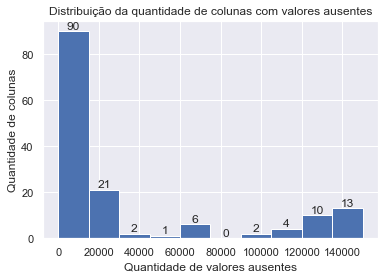

De 149 colunas, 59 possuem 10.0% ou mais de valores ausentes.
Estas colunas serão excluídas, visto que apresentam pouco valor para o nosso modelo.


In [8]:
nulls_by_column = train_treated.isnull().sum().sort_values(ascending=False)
nulls_by_column_grouped = nulls_by_column.groupby(nulls_by_column).count()
bins = np.arange(0, 150001, 15000)

values, bins, bars = plt.hist(nulls_by_column_grouped.index, weights=nulls_by_column_grouped.values, bins=bins)
plt.xlabel("Quantidade de valores ausentes")
plt.ylabel("Quantidade de colunas")
plt.title("Distribuição da quantidade de colunas com valores ausentes")
plt.bar_label(bars)

plt.show()

NULLS_BY_COLUMN_THRESHOLD = 0.10
total_rows = len(train_treated)
total_cols = len(train_treated.columns)

print(f"""De {total_cols} colunas, {nulls_by_column[nulls_by_column > total_rows * NULLS_BY_COLUMN_THRESHOLD].count()} possuem {NULLS_BY_COLUMN_THRESHOLD*100}% ou mais de valores ausentes.
Estas colunas serão excluídas, visto que apresentam pouco valor para o nosso modelo.""")

In [9]:
train_treated = train_treated.drop(columns=nulls_by_column[nulls_by_column > total_rows * NULLS_BY_COLUMN_THRESHOLD].index)

null_rows = len(train_treated[train_treated.isna().any(axis=1)])
print(f"Existem {null_rows} linhas com valores nulos de um total de {len(train_treated)} linhas. Equivalente a {round(null_rows/len(train_treated)*100, 2)}% do dataset.")

Existem 4382 linhas com valores nulos de um total de 144469 linhas. Equivalente a 3.03% do dataset.


Perfeito, ao definirmos um limite máximo de 10% de valores ausentes por coluna, já conseguimos reduzir bastante a proporção de nulos no dataset. Vamos para a próxima etapa e verificar a proporção de nulos por linhas.

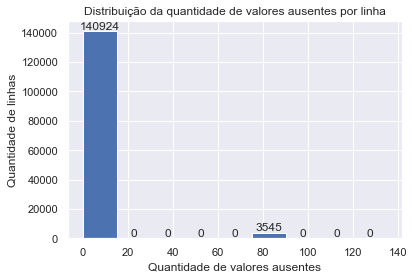

De 144469 linhas, 3545 possuem 10.0% ou mais de valores ausentes.
Estas linhas serão excluídas, visto que apresentam pouco valor para o nosso modelo.


In [10]:
nulls_by_row = train_treated.isnull().sum(axis=1).sort_values(ascending=False)
nulls_by_row_grouped = nulls_by_row.groupby(nulls_by_row).count()
bins = np.arange(0, 150, 15)

values, bins, bars = plt.hist(nulls_by_row_grouped.index, weights=nulls_by_row_grouped.values, bins=bins)
plt.xlabel("Quantidade de valores ausentes")
plt.ylabel("Quantidade de linhas")
plt.title("Distribuição da quantidade de valores ausentes por linha")
plt.bar_label(bars)

plt.show()

NULLS_BY_ROW_THRESHOLD = 0.10
total_rows = len(train_treated)
total_cols = len(train_treated.columns)

print(f"""De {total_rows} linhas, {nulls_by_row[nulls_by_row > total_cols * NULLS_BY_ROW_THRESHOLD].count()} possuem {NULLS_BY_ROW_THRESHOLD*100}% ou mais de valores ausentes.
Estas linhas serão excluídas, visto que apresentam pouco valor para o nosso modelo.""")

In [11]:
train_treated = train_treated.drop(index=nulls_by_row[nulls_by_row > total_cols * NULLS_BY_ROW_THRESHOLD].index)

null_rows = len(train_treated[train_treated.isna().any(axis=1)])
print(f"Existem {null_rows} linhas com valores nulos de um total de {len(train_treated)} linhas. Equivalente a {round(null_rows/len(train_treated)*100, 2)}% do dataset.")

Existem 837 linhas com valores nulos de um total de 140924 linhas. Equivalente a 0.59% do dataset.


Antes de partirmos para inserir os valores ausentes que sobraram é importante considerar como as classes do dataset estão fortemente desbalanceadas. Para cada bom pagador, temos quase 4 maus pagadores. Além disso, temos um grande volume de dados, por isso podemos excluir as linhas de maus pagadores com valores ausentes e focar em inserir os dados nas linhas dos bons pagadores. 

In [12]:
rows_to_drop = train_treated[train_treated["TARGET"]==1].isnull().any(axis=1)
rows_to_drop = rows_to_drop[rows_to_drop == True]

train_treated = train_treated.drop(index = rows_to_drop.index)

Perfeito, agora que excluímos as colunas positivas com valores ausentes, podemos partir para inserir os valores ausentes restantes. Para as variáveis numéricas podemos utilizar o KNNImputer, para as categóricas iremos fazer esse tratamento quando realizarmos a transformação para variáveis numéricas.

In [13]:
def impute_missing_values(dataset):
    imputer = KNNImputer()
    imputer.fit(dataset.iloc[:,:])
    dataset.iloc[:,:] = imputer.transform(dataset.iloc[:,:])

    return dataset

In [14]:
numeric_cols = train_treated.select_dtypes(include="number").columns.drop("TARGET")

train_treated[numeric_cols] = impute_missing_values(train_treated[numeric_cols])

_nulls_by_column = train_treated.isnull().sum().sort_values(ascending=False)
_nulls_by_column[_nulls_by_column>0]

VAR5      83
VAR9      73
VAR10     63
VAR142    32
dtype: int64

Perfeito, os valores nulos restantes são de váriaveis categóricas que serão tratadas depois de ser feito o encoding.

Para tratarmos as variáveis categórias precisamos entender que existem 3 grupos de váriaveis no nosso dataset:
- Variáveis nominais: Como a VAR5 e VAR148. Que não possuem uma ordem natural nas categorias, e por isso serão tratadas usando OrdinalEncoder
- Variáveis ordinais com a classificação: BAIXISSIMA, BAIXA, MEDIA, ALTA, ALTISSIMA que serão tratadas com uma função própria
- Variáveis ordinais com a classificação: MUITO PROXIMO, PROXIMO, MEDIO, LONGE, MUITO LONGE que serão tratadas com uma função própria
- Variáveis ordinais com a classificação: A, B, C, D, E que serão tratadas com uma função própria

In [15]:
def ordinal_encoding(dataset:pd.DataFrame, columns:list, values_to_replace:dict):
    return dataset[columns].replace(values_to_replace)

nominal_features = ["VAR5", "VAR148"]
ordinal_features1 = ["VAR10", "VAR66", "VAR67", "VAR68", "VAR69", "VAR70", "VAR71",
       "VAR72", "VAR73", "VAR74", "VAR75", "VAR76", "VAR77", "VAR78", "VAR79",
       "VAR80", "VAR81", "VAR82", "VAR83", "VAR84", "VAR85", "VAR86", "VAR87",
       "VAR88", "VAR89", "VAR90", "VAR91", "VAR92", "VAR93", "VAR94", "VAR95",
       "VAR96", "VAR97", "VAR98", "VAR99", "VAR100", "VAR101"]
ordinal_features2 = ["VAR102", "VAR103", "VAR104", "VAR105", "VAR106", "VAR107", "VAR108", 
       "VAR109", "VAR110", "VAR111", "VAR112", "VAR113", "VAR114", "VAR115", "VAR116",
       "VAR117", "VAR118", "VAR119", "VAR120", "VAR121", "VAR122", "VAR123", "VAR124", 
       "VAR125", "VAR126", "VAR127", "VAR128", "VAR129", "VAR130", "VAR131", "VAR132", 
       "VAR133", "VAR134", "VAR135", "VAR136", "VAR137", "VAR138", "VAR139", "VAR140"]
ordinal_features3 = ["VAR9", "VAR142"]

values_to_replace1 = {"BAIXISSIMA":0, "BAIXA":1, "MEDIA":2, "ALTA":3, "ALTISSIMA":4}
values_to_replace2 = {"MUITO PROXIMO":0, "PROXIMO":1, "MEDIO":2, "LONGE":3, "MUITO LONGE":4}
values_to_replace3 = {"A":0, "B":1, "C":2, "D":3, "E":4}

In [16]:
train_treated[ordinal_features1] = ordinal_encoding(train_treated, ordinal_features1, values_to_replace1)
train_treated[ordinal_features2] = ordinal_encoding(train_treated, ordinal_features2, values_to_replace2)
train_treated[ordinal_features3] = ordinal_encoding(train_treated, ordinal_features3, values_to_replace3)

In [26]:
def encode_data(dataset:pd.DataFrame, features:list):
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    return encoder.fit_transform(dataset[features])

train_treated[nominal_features] = encode_data(train_treated, nominal_features)

train_treated[["VAR5", "VAR9", "VAR10", "VAR142"]] = impute_missing_values(train_treated[["VAR5", "VAR9", "VAR10", "VAR142"]])

In [27]:
train_treated

,TARGET,VAR5,VAR6,VAR7,VAR9,VAR10,VAR39,VAR40,VAR41,VAR47,VAR66,VAR67,VAR68,VAR69,VAR70,VAR71,VAR72,VAR73,VAR74,VAR75,VAR76,VAR77,VAR78,VAR79,VAR80,VAR81,VAR82,VAR83,VAR84,VAR85,VAR86,VAR87,VAR88,VAR89,VAR90,VAR91,VAR92,VAR93,VAR94,VAR95,VAR96,VAR97,VAR98,VAR99,VAR100,VAR101,VAR102,VAR103,VAR104,VAR105,VAR106,VAR107,VAR108,VAR109,VAR110,VAR111,VAR112,VAR113,VAR114,VAR115,VAR116,VAR117,VAR118,VAR119,VAR120,VAR121,VAR122,VAR123,VAR124,VAR125,VAR126,VAR127,VAR128,VAR129,VAR130,VAR131,VAR132,VAR133,VAR134,VAR135,VAR136,VAR137,VAR138,VAR139,VAR140,VAR141,VAR142,VAR147,VAR148,VAR149
0,1,25.0,-23.549841,-46.959865,4.0,3.0,0.378548,0.451697,0.438720,1.000,2,3,2,3,2,2,3,3,3,2,3,3,2,3,2,2,3,3,3,3,2,2,2,3,0,2,2,3,3,3,2,3,3,2,4,2,3,2,3,3,3,2,3,1,2,2,3,2,2,3,3,2,2,3,4,2,3,3,3,2,2,2,3,3,2,3,2,2,2,3,1,3,2,3,2,1399.037809,4.0,102.0,0.0,2.6.1
1,1,4.0,-12.924251,-38.487840,4.0,3.0,0.476678,0.401271,0.393429,0.000,3,0,4,3,4,3,3,3,4,4,4,2,4,4,3,3,4,3,4,4,3,3,4,3,4,4,4,0,4,3,3,3,4,3,4,3,2,2,1,2,3,3,3,1,2,1,2,2,2,1,2,1,0,1,4,1,2,2,2,2,3,1,2,1,3,1,2,2,2,1,1,2,2,2,2,1516.196234,4.0,102.0,0.0,2.6.1
2,1,16.0,-5.063743,-42.761499,4.0,2.0,0.532506,0.484427,0.546715,1.000,4,3,3,3,4,4,3,0,4,4,3,3,4,0,4,4,3,2,3,3,0,4,3,4,4,3,4,4,3,3,4,2,4,4,4,4,3,2,3,2,1,2,1,0,3,1,1,2,3,4,1,3,2,1,4,3,1,4,2,1,2,1,3,3,2,1,2,2,1,1,1,3,2,2,2,1727.153575,4.0,102.0,0.0,2.6.1
3,1,13.0,-0.623754,-47.345800,4.0,4.0,0.273552,0.533198,0.786395,0.000,2,0,0,0,2,2,0,2,2,0,0,0,0,0,0,1,0,0,0,0,2,3,1,2,0,1,0,0,2,0,1,0,0,2,0,0,3,0,3,4,4,4,0,4,3,0,4,4,4,3,4,4,4,1,4,1,3,4,0,4,3,4,4,4,4,0,4,4,4,4,4,4,4,3,4,1627.157652,4.0,102.0,0.0,2.6.1
4,1,22.0,-28.460032,-52.820856,4.0,4.0,0.682983,0.770025,0.959874,0.503,2,0,0,2,2,2,0,0,2,2,2,0,2,0,0,2,0,0,0,2,2,2,2,2,0,2,2,0,2,0,2,2,0,2,0,0,3,3,3,4,3,4,3,3,4,3,3,3,4,4,0,4,3,4,1,3,3,3,3,3,3,3,3,3,4,3,3,3,4,0,3,4,4,4,0,2133.992676,3.0,102.0,0.0,2.6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144464,0,5.0,-3.783943,-38.499671,4.0,2.0,0.360449,0.495547,0.489868,0.348,4,4,4,3,4,3,3,3,4,4,2,4,4,4,4,4,4,4,4,4,4,3,4,4,0,4,4,4,3,3,4,3,4,4,0,4,1,1,1,2,2,2,2,2,3,2,1,3,2,2,3,1,1,1,4,3,1,3,3,1,1,1,2,2,1,2,2,3,1,2,2,2,2,2,1,2619.739069,3.0,102.0,0.0,2.6.1
144465,1,19.0,-5.236030,-37.307541,4.0,1.0,0.416111,0.494292,0.471838,1.000,3,3,3,0,3,4,2,0,3,3,2,0,3,3,0,4,0,3,3,3,3,3,4,2,0,4,3,3,3,4,4,4,3,4,0,4,2,3,0,4,0,1,3,2,3,3,3,3,3,3,3,3,1,2,4,1,3,0,2,3,3,3,3,3,2,2,3,2,2,3,4,2,3,2,4,1754.097923,4.0,102.0,0.0,2.6.1
144466,1,22.0,-29.907806,-51.214072,4.0,3.0,0.537685,0.564752,0.609252,0.001,3,0,3,3,2,2,3,3,3,3,2,2,2,3,3,2,0,4,3,4,3,3,3,3,4,2,4,0,3,0,3,4,3,3,0,3,2,3,2,3,3,3,1,1,2,3,3,3,2,3,2,3,2,1,4,1,1,2,3,2,2,1,3,2,3,2,1,1,3,2,2,3,3,3,2,4413.353013,2.0,102.0,0.0,2.6.1
144467,1,10.0,-16.213169,-44.433649,4.0,4.0,0.381003,0.855777,0.916315,1.000,2,0,0,0,2,2,0,0,2,2,0,0,0,0,0,3,0,0,0,2,2,2,2,0,0,2,2,0,0,3,2,2,0,3,0,2,4,3,4,4,3,3,3,4,4,3,3,4,4,4,0,3,4,4,4,4,3,3,0,1,4,4,3,3,3,4,3,3,4,3,4,4,3,3,4,1586.935378,4.0,102.0,0.0,2.6.1
